# **Navigation/Mount/Env**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Project Folder
%cd "gdrive/My Drive/projects/dermo/scripts/" 

/content/gdrive/My Drive/projects/dermo/scripts


In [ ]:
# Current Directory
%ls

classification_models/  delta.ipynb    iowa.ipynb
color-io.ipynb          epsilon.ipynb  __pycache__/


In [ ]:
# Libraries
import glob
import numpy as np
import cv2
from skimage import filters as skifilters
from scipy import ndimage
from skimage import filters
import matplotlib.pyplot as plt
import tqdm
from sklearn.utils import shuffle
import pandas as pd
from __future__ import unicode_literals
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
import os
import h5py
import time
import json
import warnings
from PIL import Image

# **I/O**

## **● Dataset**

In [ ]:
def findScan(data, name, key):
    """"
    Input: 
        data     - dict of dict to sort the data
        key      - key of 'data' ('id','image','label')
        value    - value of 'key'
    Output:
        value
    """
    for i, dic in data.items():
        if dic[key] == name:        
            return i
    return -1


def sortData(path, mode='train-val', disp=True, mask=False, mask_mode=False):
    """"
    Input:  path
    Output: data[p] = {
        'id':
        'image':
        'label': }
    """
    if (mode=='train-val'):
        # Importing Images
        les_dir = glob.glob(path+"/les/*.jpg")
        nv_dir  = glob.glob(path+"/nv/*.jpg")
        if (disp==True):
            print("Number of LES Images:", len(les_dir))
            print("Number of NV Images:",  len(nv_dir))

        if (mask==True):
            # Importing Masks
            masks_les_dir = glob.glob(path+"/masks_"+mask_mode+"/les/*.jpg")
            masks_nv_dir  = glob.glob(path+"/masks_"+mask_mode+"/nv/*.jpg")
            if (disp==True):
                print("Number of LES Masks:", len(masks_les_dir))
                print("Number of NV Masks:",  len(masks_nv_dir))
            # Creating Dictionary (LES Scans)
            data = {}
            for p in range(len(les_dir)):
                scan_id  =  les_dir[p].replace(".jpg", "")
                scan_id  =  scan_id.replace(path+"/les/", "")
                # Creating List of Dictionary                    
                data[p] = {
                            'id'    : scan_id,
                            'image' : les_dir[p],
                            'mask'  : masks_les_dir[p],
                            'label' : 1 }            # Label of LES = 1
            # Creating Dictionary (NV Scans)
            for p in range(len(nv_dir)):
                scan_id  =  nv_dir[p].replace(".jpg", "")
                scan_id  =  scan_id.replace(path+"/nv/", "")
                # Creating List of Dictionary                    
                data[p+len(les_dir)] = {
                            'id'    : scan_id,
                            'image' : nv_dir[p],
                            'mask'  : masks_nv_dir[p],                
                            'label' : 0 }            # Label of NV = 0
        
        if (mask==False):
            # Creating Dictionary (LES Scans)
            data = {}
            for p in range(len(les_dir)):
                scan_id  =  les_dir[p].replace(".jpg", "")
                scan_id  =  scan_id.replace(path+"/les/", "")
                # Creating List of Dictionary                    
                data[p] = {
                            'id'    : scan_id,
                            'image' : les_dir[p],
                            'label' : 1 }            # Label of LES = 1
            # Creating Dictionary (NV Scans)
            for p in range(len(nv_dir)):
                scan_id  =  nv_dir[p].replace(".jpg", "")
                scan_id  =  scan_id.replace(path+"/nv/", "")
                # Creating List of Dictionary                    
                data[p+len(les_dir)] = {
                            'id'    : scan_id,
                            'image' : nv_dir[p],
                            'label' : 0 }            # Label of NV = 0

    if (mode=='test'):
        # Importing Images
        target_dir  = glob.glob(path+"/*.jpg")
        if (disp==True):
            print("Number of Test Images:", len(target_dir))
        # Creating Dictionary
        data = {}
        for p in range(len(target_dir)):
            scan_id  =  target_dir[p].replace(".jpg", "")
            scan_id  =  scan_id.replace("../data/original/test/", "")
            # Creating List of Dictionary                    
            data[p] = {
                        'id'    : scan_id,
                        'image' : target_dir[p] }
    return data

def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask

# **Color Transformation**

In [ ]:
def shades_gray(image, njet=0, mink_norm=1, sigma=1):
    """
    Estimates the light source of an input_image as proposed in:
    J. van de Weijer, Th. Gevers, A. Gijsenij
    "Edge-Based Color Constancy"
    IEEE Trans. Image Processing, accepted 2007.
    Depending on the parameters the estimation is equal to Grey-World, Max-RGB, general Grey-World,
    Shades-of-Grey or Grey-Edge algorithm.
    :param image: rgb input image (NxMx3)
    :param njet: the order of differentiation (range from 0-2)
    :param mink_norm: minkowski norm used (if mink_norm==-1 then the max
           operation is applied which is equal to minkowski_norm=infinity).
    :param sigma: sigma used for gaussian pre-processing of input image
    :return: illuminant color estimation
    :raise: ValueError
    
    Ref: https://github.com/MinaSGorgy/Color-Constancy
    """
    gauss_image = filters.gaussian(image, sigma=sigma, multichannel=True)
    if njet == 0:
        deriv_image = [gauss_image[:, :, channel] for channel in range(3)]
    else:   
        if njet == 1:
            deriv_filter = filters.sobel
        elif njet == 2:
            deriv_filter = filters.laplace
        else:
            raise ValueError("njet should be in range[0-2]! Given value is: " + str(njet))     
        deriv_image = [np.abs(deriv_filter(gauss_image[:, :, channel])) for channel in range(3)]
    for channel in range(3):
        deriv_image[channel][image[:, :, channel] >= 255] = 0.
    if mink_norm == -1:  
        estimating_func = np.max 
    else:
        estimating_func = lambda x: np.power(np.sum(np.power(x, mink_norm)), 1 / mink_norm)
    illum = [estimating_func(channel) for channel in deriv_image]
    som   = np.sqrt(np.sum(np.power(illum, 2)))
    illum = np.divide(illum, som)
    return illum


def correct_image(image, illum):
    """
    Corrects image colors by performing diagonal transformation according to 
    given estimated illumination of the image.
    :param image: rgb input image (NxMx3)
    :param illum: estimated illumination of the image
    :return: corrected image
    
    Ref: https://github.com/MinaSGorgy/Color-Constancy
    """
    correcting_illum = illum * np.sqrt(3)
    corrected_image = image / 255.
    for channel in range(3):
        corrected_image[:, :, channel] /= correcting_illum[channel]
    return np.clip(corrected_image, 0., 1.)

## **● NPY/RAW**

In [ ]:
# Single-Time Execution to Create Color-Transformed Input Images

mode           = 'execute'    # 'demo'/'execute' 
export_mode    = 'RAW'        # 'NPY'/'RAW'
circular_mask  = False     

# Load Datasets
train_data = sortData('../data/original/train/', mode='train-val', disp=False)
val_data   = sortData('../data/original/val/',   mode='train-val', disp=False)
    
if (mode=='demo'):
    # Pass Demo Image
    index     = findScan(train_data,'nv0257','id')
    sample    = plt.imread(train_data[index]['image'])
    print(train_data[index]['id'])
    
    # Color Transformations
    mx  = correct_image(sample, shades_gray(sample, njet=0, mink_norm=-1, sigma=0))  # MaxRGB Constancy
    gw  = correct_image(sample, shades_gray(sample, njet=0, mink_norm=+1, sigma=0))  # Gray World Constancy 
    hsv = cv2.cvtColor(sample, cv2.COLOR_RGB2HSV)                                    # HSV Color Space
    lab = cv2.cvtColor(sample, cv2.COLOR_RGB2Lab)                                    # CIELab Color Space
    
    # Concatenate to Output Image
    op    = np.concatenate((gw/255,np.expand_dims(hsv[:,:,0]/179,axis=2),hsv[:,:,1:]/255, lab/255),axis=2)
    
    # Masking Image
    if (circular_mask==True):
      circa_mask            = create_circular_mask(op.shape[0], op.shape[1], radius=200).astype(bool)
      op                    = np.multiply(op, np.dstack((circa_mask,circa_mask,circa_mask,circa_mask,circa_mask,
                                                         circa_mask,circa_mask,circa_mask,circa_mask)))
    print('Preprocessed Shape: ' + str(op.shape))

elif (mode=='execute'):
    # Transform Training Images
    for index in tqdm.tqdm(range(0,len(train_data))):
        
        # Load Dataset
        image    = plt.imread(train_data[index]['image'])
        scan_id  = train_data[index]['id']
        label    = train_data[index]['label']
        
        # Color Transformations
        mx    = correct_image(image, shades_gray(image, njet=0, mink_norm=-1, sigma=0))  # MaxRGB Constancy
        gw    = correct_image(image, shades_gray(image, njet=0, mink_norm=+6, sigma=0))  # Gray World Constancy 
        hsv   = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)                                   # HSV Color Space
        lab   = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)                                   # CIELab Color Space
        
        # Concatenate to Output Image
        op    = np.concatenate((gw/255,np.expand_dims(hsv[:,:,0]/179,axis=2),hsv[:,:,1:]/255, lab/255),axis=2)
        
        # Masking Image
        if (circular_mask==True):
          circa_mask            = create_circular_mask(op.shape[0], op.shape[1], radius=200).astype(bool)
          op                    = np.multiply(op, np.dstack((circa_mask,circa_mask,circa_mask,circa_mask,circa_mask,
                                                             circa_mask,circa_mask,circa_mask,circa_mask)))
        
        if (export_mode=='NPY'):
          if (label==1):
              np.save('../data/npy/train/les/'+str(scan_id)+'.npy',op)
          if (label==0):
              np.save('../data/npy/train/nv/'+str(scan_id)+'.npy',op)
        if (export_mode=='RAW'):
          if (label==1):
              op.astype(np.float32).tofile('../data/raw/train/les/'+str(scan_id)+'.raw')
          if (label==0):
              op.astype(np.float32).tofile('../data/raw/train/nv/'+str(scan_id)+'.raw')
                  
    
    # Transform Validation Images
    for index in tqdm.tqdm(range(0,len(val_data))):
        
        # Load Dataset
        image    = plt.imread(val_data[index]['image'])
        scan_id  = val_data[index]['id']
        label    = val_data[index]['label']
        
        # Color Transformations
        mx    = correct_image(image, shades_gray(image, njet=0, mink_norm=-1, sigma=0))  # MaxRGB Constancy
        gw    = correct_image(image, shades_gray(image, njet=0, mink_norm=+1, sigma=0))  # Gray World Constancy 
        hsv   = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)                                   # HSV Color Space
        lab   = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)                                   # CIELab Color Space
        
        # Concatenate to Output Image
        op    = np.concatenate((gw/255,np.expand_dims(hsv[:,:,0]/179,axis=2),hsv[:,:,1:]/255,
                                np.expand_dims(lab[:,:,0]/255,axis=2),lab[:,:,1:]/128),axis=2)

        # Masking Image
        if (circular_mask==True):
          circa_mask            = create_circular_mask(op.shape[0], op.shape[1], radius=200).astype(bool)
          op                    = np.multiply(op, np.dstack((circa_mask,circa_mask,circa_mask,circa_mask,circa_mask,
                                                             circa_mask,circa_mask,circa_mask,circa_mask)))        
        
        if (export_mode=='NPY'):
          if (label==1):
              np.save('../data/npy/val/les/'+str(scan_id)+'.npy',op)
          if (label==0):
              np.save('../data/npy/val/nv/'+str(scan_id)+'.npy',op)
        if (export_mode=='RAW'):
          if (label==1):
              op.astype(np.float32).tofile('../data/raw/val/les/'+str(scan_id)+'.raw')
          if (label==0):
              op.astype(np.float32).tofile('../data/raw/val/nv/'+str(scan_id)+'.raw')

(450, 600, 3)

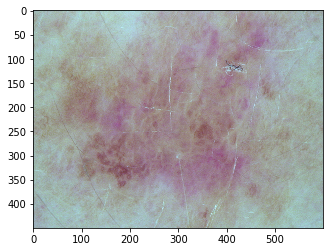

In [ ]:
# Verify Transformed NPY Dataset
plt.imshow(op[:,:,:3]*255)
sample.shape

## **● Gray World/MaxRGB Images**

In [32]:
# Single-Time Execution to Create Color-Transformed Input Images
mode           = 'execute'    # 'demo'/'execute' 
circular_mask  = False

# Load Datasets
train_data = sortData('../data/original/full/',   mode='train-val', disp=False)
val_data   = sortData('../data/original/test/',   mode='train-val', disp=False)
    
if (mode=='demo'):
    # Pass Demo Image
    index     = findScan(train_data,'nv0257','id')
    sample    = plt.imread(train_data[index]['image'])
    print(train_data[index]['id'])
    
    # Color Transformations
    mx  = correct_image(sample, shades_gray(sample, njet=0, mink_norm=-1, sigma=0))  # MaxRGB Constancy
    gw  = correct_image(sample, shades_gray(sample, njet=0, mink_norm=+1, sigma=0))  # Gray World Constancy 
    hsv = cv2.cvtColor(sample, cv2.COLOR_RGB2HSV)                                    # HSV Color Space
    lab = cv2.cvtColor(sample, cv2.COLOR_RGB2Lab)                                    # CIELab Color Space
    
    # Concatenate to Output Image
    op  = np.concatenate((sample,mx,gw,hsv,lab),axis=2)

    # Masking Image
    if (circular_mask==True):
      circa_mask            = create_circular_mask(gw.shape[0], gw.shape[1], radius=200).astype(bool)
      gw                    = np.multiply(gw, np.dstack((circa_mask,circa_mask,circa_mask)))  
        
    print('Preprocessed Shape: ' + str(op.shape))

elif (mode=='execute'):
    # Transform Training Images
    for index in tqdm.tqdm(range(0,len(train_data))):
        
        # Load Dataset
        image    = plt.imread(train_data[index]['image'])
        scan_id  = train_data[index]['id']
        label    = train_data[index]['label']
        
        # Color Transformations
        mx    = correct_image(image, shades_gray(image, njet=0, mink_norm=-1, sigma=0))  # MaxRGB Constancy
        gw    = correct_image(image, shades_gray(image, njet=0, mink_norm=+6, sigma=0))  # Gray World Constancy 
        hsv   = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)                                   # HSV Color Space
        lab   = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)                                   # CIELab Color Space
        
        # Masking Image
        if (circular_mask==True):
          circa_mask            = create_circular_mask(gw.shape[0], gw.shape[1], radius=200).astype(bool)
          gw                    = np.multiply(gw, np.dstack((circa_mask,circa_mask,circa_mask))) 
        
        if (label==1):
            imo = Image.fromarray((gw*255).astype(np.uint8))
            imo.save('../data/grayworld/full/les/'+str(scan_id)+'.png')
        if (label==0):
            imo = Image.fromarray((gw*255).astype(np.uint8))
            imo.save('../data/grayworld/full/nv/'+str(scan_id)+'.png')

100%|██████████| 6000/6000 [27:44<00:00,  3.32it/s]


In [33]:
# Transform Validation Images
test_data   = sortData('../data/original/test/',   mode='test', disp=False)
for index in tqdm.tqdm(range(0,len(test_data))):
    
    # Load Dataset
    image    = plt.imread(test_data[index]['image'])
    scan_id  = test_data[index]['id']
    
    # Color Transformations
    mx    = correct_image(image, shades_gray(image, njet=0, mink_norm=-1, sigma=0))  # MaxRGB Constancy
    gw    = correct_image(image, shades_gray(image, njet=0, mink_norm=+6, sigma=0))  # Gray World Constancy 
    hsv   = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)                                   # HSV Color Space
    lab   = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)                                   # CIELab Color Space
    
    imo = Image.fromarray((gw*255).astype(np.uint8))
    imo.save('../data/grayworld/test/'+str(scan_id)+'.png')

100%|██████████| 1015/1015 [04:45<00:00,  3.78it/s]
